## Analysis of Integrated multi-omics single cell atlas of the human retina
- QC
- EDA
- Clustering
- Clustering Analysis

In [40]:
import sys
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import dill
import matplotlib.pyplot as plt

In [41]:
sys.version

'3.10.5 (main, Jul 19 2022, 08:28:45) [GCC 6.2.0]'

In [42]:
# Notification System
def speak(text):
    from IPython.display import Javascript as js, clear_output
    # Escape single quotes
    text = text.replace("'", r"\'")
    display(js('''
    if(window.speechSynthesis) {{
        var synth = window.speechSynthesis;
        synth.speak(new window.SpeechSynthesisUtterance('{text}'));
    }}
    '''.format(text=text)))
    # Clear the JS so that the notebook doesn't speak again when reopened/refreshed
    clear_output(False)

In [43]:
adata = sc.read_h5ad("d0183df5-815d-48c2-bcfe-fbf9b716505c.h5ad")

In [44]:
print(adata)

AnnData object with n_obs × n_vars = 330930 × 32034
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'pANN', 'sampleid', 'subclass_label', 'majorclass', 'author_cell_type', 'age', 'gender', 'reference', 'accession', 'sample_note', 'development_stage_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'donor_id', 'organism_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'tissue_type', 'library_platform', 'cell_type_ontology_term_id', 'is_primary_data', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'gene_symbols', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'
    uns: 'citation', 'default_embedding', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_scVI', 'X_umap'


In [45]:
display(adata.obs.head())
display(adata.var.head())

,nCount_RNA,nFeature_RNA,percent.mt,pANN,sampleid,subclass_label,majorclass,author_cell_type,age,gender,...,is_primary_data,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid
10x3_Ms_WT_P14_AAACCCAAGGGATCTG-1,8090.0,3062.0,9.431397,0.191304,10x3_Ms_WT_P14,NaN,BC,RBC,P14,Male,...,True,rod bipolar cell,10x 3' v3,normal,Mus musculus,male,retina,na,2 weeks,O;1d2cRM*r
10x3_Ms_WT_P14_AAACCCACATGGATCT-1,8397.0,3145.0,7.264499,0.217391,10x3_Ms_WT_P14,NaN,BC,RBC,P14,Male,...,True,rod bipolar cell,10x 3' v3,normal,Mus musculus,male,retina,na,2 weeks,<&_ecXlzow
10x3_Ms_WT_P14_AAAGTCCAGCTGAAGC-1,11927.0,3686.0,8.325648,0.200000,10x3_Ms_WT_P14,NaN,BC,RBC,P14,Male,...,True,rod bipolar cell,10x 3' v3,normal,Mus musculus,male,retina,na,2 weeks,o(0Cc`LhFQ
10x3_Ms_WT_P14_AAATGGAGTCACCCTT-1,10331.0,3621.0,6.427258,0.173913,10x3_Ms_WT_P14,NaN,BC,RBC,P14,Male,...,True,rod bipolar cell,10x 3' v3,normal,Mus musculus,male,retina,na,2 weeks,)?i*V-3{5!
10x3_Ms_WT_P14_AACACACCAGAACTAA-1,11236.0,3739.0,6.034176,0.165217,10x3_Ms_WT_P14,NaN,BC,RBC,P14,Male,...,True,rod bipolar cell,10x 3' v3,normal,Mus musculus,male,retina,na,2 weeks,<?%Qa*+>_>


,gene_symbols,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length
ENSMUSG00000109644,0610005C13Rik,False,0610005C13Rik,NCBITaxon:10090,gene,3588
ENSMUSG00000108652,0610006L08Rik,False,0610006L08Rik,NCBITaxon:10090,gene,2128
ENSMUSG00000007777,0610009B22Rik,False,0610009B22Rik,NCBITaxon:10090,gene,998
ENSMUSG00000086714,0610009E02Rik,False,0610009E02Rik,NCBITaxon:10090,gene,2977
ENSMUSG00000043644,0610009L18Rik,False,0610009L18Rik,NCBITaxon:10090,gene,1394


## QC

In [46]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var['feature_name'].str.startswith("mt-")

In [47]:
adata.var[adata.var["mt"]]

,gene_symbols,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length,mt
ENSMUSG00000064357,mt-Atp6,False,mt-Atp6,NCBITaxon:10090,gene,681,True
ENSMUSG00000064356,mt-Atp8,False,mt-Atp8,NCBITaxon:10090,gene,204,True
ENSMUSG00000064351,mt-Co1,False,mt-Co1,NCBITaxon:10090,gene,1545,True
ENSMUSG00000064354,mt-Co2,False,mt-Co2,NCBITaxon:10090,gene,684,True
ENSMUSG00000064358,mt-Co3,False,mt-Co3,NCBITaxon:10090,gene,784,True
ENSMUSG00000064370,mt-Cytb,False,mt-Cytb,NCBITaxon:10090,gene,1144,True
ENSMUSG00000064341,mt-Nd1,False,mt-Nd1,NCBITaxon:10090,gene,957,True
ENSMUSG00000064345,mt-Nd2,False,mt-Nd2,NCBITaxon:10090,gene,1038,True
ENSMUSG00000064360,mt-Nd3,False,mt-Nd3,NCBITaxon:10090,gene,348,True
ENSMUSG00000064363,mt-Nd4,False,mt-Nd4,NCBITaxon:10090,gene,1378,True


In [48]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], inplace=True, log1p=True
)

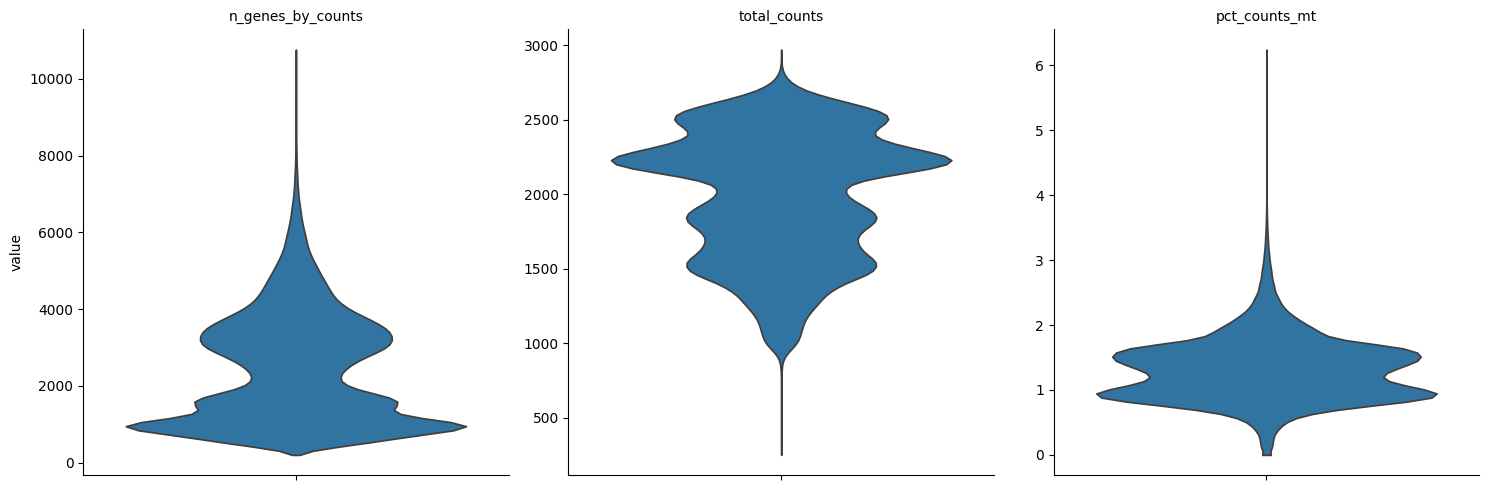

In [49]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    stripplot = False,
    multi_panel=True,
)

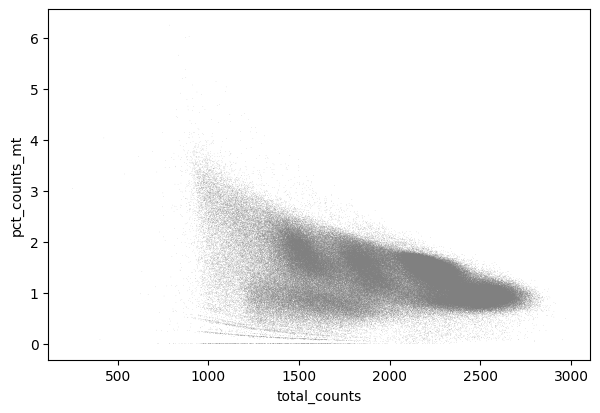

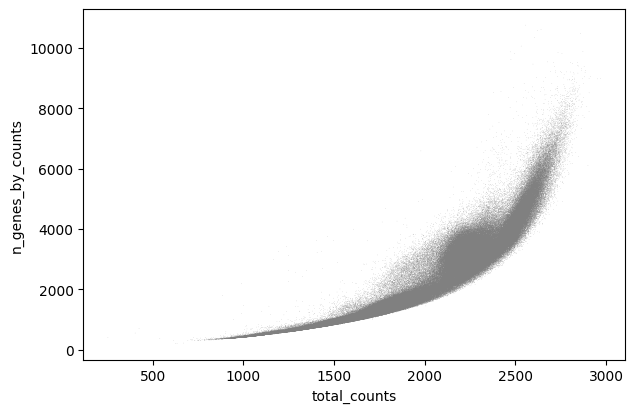

In [50]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

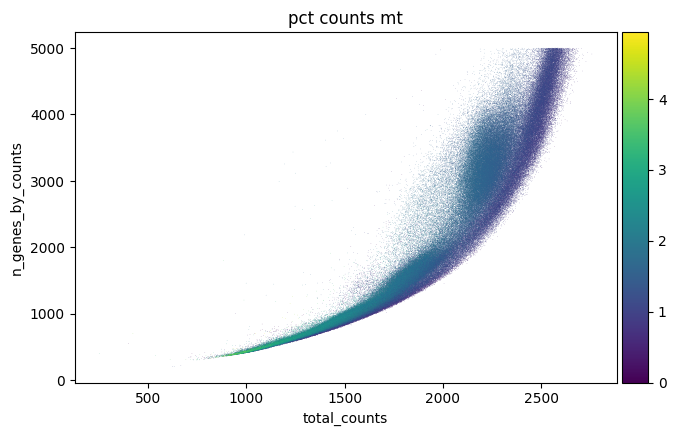

In [96]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [95]:
pd.options.display.max_columns = None

adata.obs.head()

,nCount_RNA,nFeature_RNA,percent.mt,pANN,sampleid,subclass_label,majorclass,author_cell_type,age,gender,reference,accession,sample_note,development_stage_ontology_term_id,tissue_ontology_term_id,assay_ontology_term_id,disease_ontology_term_id,donor_id,organism_ontology_term_id,self_reported_ethnicity_ontology_term_id,sex_ontology_term_id,suspension_type,tissue_type,library_platform,cell_type_ontology_term_id,is_primary_data,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,leiden_res_0.02,leiden_res_0.50,leiden_res_2.00
10x3_Ms_WT_P14_AAACCCAAGGGATCTG-1,8090.0,3062.0,9.431397,0.191304,10x3_Ms_WT_P14,NaN,BC,RBC,P14,Male,GSE243413 (2023) WT_CD73,GSE243413,NaN,MmusDv:0000046,UBERON:0000966,EFO:0009922,PATO:0000461,pooled_10x3_Ms_WT_P14,NCBITaxon:10090,na,PATO:0000384,cell,tissue,10x-3'-v3,CL:0000751,True,rod bipolar cell,10x 3' v3,normal,Mus musculus,male,retina,na,2 weeks,O;1d2cRM*r,3056,8.025189,2197.756836,7.695647,6.627282,11.206648,18.703447,35.566470,34.262024,3.562807,1.558954,0,0,0
10x3_Ms_WT_P14_AAACCCACATGGATCT-1,8397.0,3145.0,7.264499,0.217391,10x3_Ms_WT_P14,NaN,BC,RBC,P14,Male,GSE243413 (2023) WT_CD73,GSE243413,NaN,MmusDv:0000046,UBERON:0000966,EFO:0009922,PATO:0000461,pooled_10x3_Ms_WT_P14,NCBITaxon:10090,na,PATO:0000384,cell,tissue,10x-3'-v3,CL:0000751,True,rod bipolar cell,10x 3' v3,normal,Mus musculus,male,retina,na,2 weeks,<&_ecXlzow,3139,8.051978,2218.916992,7.705225,6.564354,11.038934,18.514623,35.060276,33.661476,3.545629,1.517023,0,0,0
10x3_Ms_WT_P14_AAAGTCCAGCTGAAGC-1,11927.0,3686.0,8.325648,0.200000,10x3_Ms_WT_P14,NaN,BC,RBC,P14,Male,GSE243413 (2023) WT_CD73,GSE243413,NaN,MmusDv:0000046,UBERON:0000966,EFO:0009922,PATO:0000461,pooled_10x3_Ms_WT_P14,NCBITaxon:10090,na,PATO:0000384,cell,tissue,10x-3'-v3,CL:0000751,True,rod bipolar cell,10x 3' v3,normal,Mus musculus,male,retina,na,2 weeks,o(0Cc`LhFQ,3678,8.210396,2222.557861,7.706864,6.735849,11.331282,18.874265,35.074913,35.927227,3.608949,1.616481,0,0,0
10x3_Ms_WT_P14_AAATGGAGTCACCCTT-1,10331.0,3621.0,6.427258,0.173913,10x3_Ms_WT_P14,NaN,BC,RBC,P14,Male,GSE243413 (2023) WT_CD73,GSE243413,NaN,MmusDv:0000046,UBERON:0000966,EFO:0009922,PATO:0000461,pooled_10x3_Ms_WT_P14,NCBITaxon:10090,na,PATO:0000384,cell,tissue,10x-3'-v3,CL:0000751,True,rod bipolar cell,10x 3' v3,normal,Mus musculus,male,retina,na,2 weeks,)?i*V-3{5!,3611,8.192017,2280.132324,7.732427,6.358029,10.783757,17.909796,33.453434,31.818954,3.491006,1.395487,0,0,0
10x3_Ms_WT_P14_AACACACCAGAACTAA-1,11236.0,3739.0,6.034176,0.165217,10x3_Ms_WT_P14,NaN,BC,RBC,P14,Male,GSE243413 (2023) WT_CD73,GSE243413,NaN,MmusDv:0000046,UBERON:0000966,EFO:0009922,PATO:0000461,pooled_10x3_Ms_WT_P14,NCBITaxon:10090,na,PATO:0000384,cell,tissue,10x-3'-v3,CL:0000751,True,rod bipolar cell,10x 3' v3,normal,Mus musculus,male,retina,na,2 weeks,<?%Qa*+>_>,3734,8.225503,2314.914062,7.747560,6.263433,10.658214,17.735495,33.362328,31.138792,3.470064,1.345138,0,0,0


### Mitochondrial Sanity Check

In [51]:
# Get the mitochondrial genes
mitochondrial_genes = adata.var[adata.var['mt']]

# Get the names of mitochondrial genes
mitochondrial_genes_names = mitochondrial_genes['feature_name']

def print_gene_expression(cell_of_interest):
    # Get the gene expression values for mitochondrial genes for the specified cell
    gene_expression = adata[cell_of_interest, adata.var['mt']].X
    
    # Convert the sparse matrix to a dense array if necessary
    if hasattr(gene_expression, "toarray"):
        gene_expression = gene_expression.toarray()
    
    # Get the percent.mt value for the cell
    percent_mt = adata.obs.loc[cell_of_interest, 'percent.mt']
    
    # Display the gene expression values
    print(f"\nGene expression values for mitochondrial genes in {cell_of_interest} (percent.mt: {percent_mt:.2f}%):")
    for gene, expr in zip(mitochondrial_genes_names, gene_expression.flatten()):  # .flatten() to ensure it's a 1D array
        print(f"{gene}: {expr}")

# Specify the first cell by its index position
cell_mt_max = adata.obs['percent.mt'].idxmax()

# Find the cell with the highest percent.mt
cell_mt_min = adata.obs['percent.mt'].idxmin()

# Get the mitochondrial genes
mitochondrial_genes = adata.var[adata.var['mt']]

# Get the names of mitochondrial genes
mitochondrial_genes_names = mitochondrial_genes['feature_name']

# Print gene expression for the first cell
print_gene_expression(cell_mt_max)

# Print gene expression for the cell with the highest percent.mt
print_gene_expression(cell_mt_min)



Gene expression values for mitochondrial genes in 10x3_Ms_WT_P14_GTGTGGCGTCAACGCC-1 (percent.mt: 10.00%):
mt-Atp6: 4.5594353675842285
mt-Atp8: 1.276137351989746
mt-Co1: 4.33620548248291
mt-Co2: 4.414199352264404
mt-Co3: 4.6017842292785645
mt-Cytb: 4.039323806762695
mt-Nd1: 2.7384846210479736
mt-Nd2: 2.3319485187530518
mt-Nd3: 1.8189771175384521
mt-Nd4: 2.833989381790161
mt-Nd4l: 1.6355808973312378
mt-Nd5: 1.529503345489502
mt-Nd6: 0.4164412021636963

Gene expression values for mitochondrial genes in 10x3_Ms_WT_P14_AAGAACAGTATTAAGG-1 (percent.mt: 0.00%):
mt-Atp6: 0.0
mt-Atp8: 0.0
mt-Co1: 0.0
mt-Co2: 0.0
mt-Co3: 0.0
mt-Cytb: 0.0
mt-Nd1: 0.0
mt-Nd2: 0.0
mt-Nd3: 0.0
mt-Nd4: 0.0
mt-Nd4l: 0.0
mt-Nd5: 0.0
mt-Nd6: 0.0


### Filtering Cells

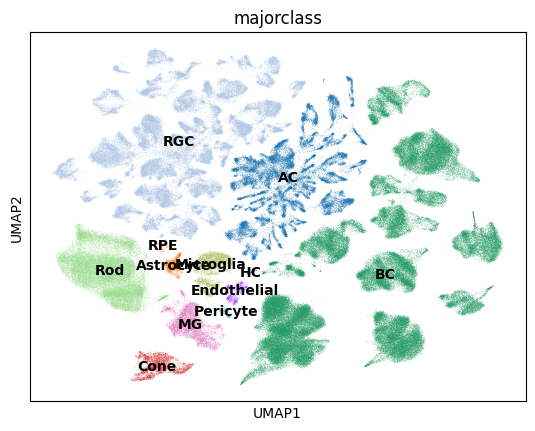

In [52]:
sc.pl.umap(
    adata,
    color=["majorclass"],
    wspace=.2,
    legend_loc="on data",
)

In [53]:
# Define filter thresholds
min_genes = 200
max_genes = 5000
min_counts = 1000
max_counts = 1e5
max_percent_mt = 5

# Create a copy of adata to apply filters
filtered_adata = adata.copy()

# Initial number of cells
initial_cells = filtered_adata.shape[0]

# Apply the first filter
before_filter1 = filtered_adata.shape[0]
filtered_adata = filtered_adata[filtered_adata.obs['n_genes_by_counts'] < max_genes, :]
after_filter1 = filtered_adata.shape[0]
removed_filter1 = before_filter1 - after_filter1

print(f"Filter 1: Cells with n_genes_by_counts < {max_genes}")
print(f"Before filter: {before_filter1} cells")
print(f"After filter: {after_filter1} cells")
print(f"Removed: {removed_filter1} cells\n")

# Apply the second filter
before_filter2 = filtered_adata.shape[0]
filtered_adata = filtered_adata[filtered_adata.obs['total_counts'] < max_counts, :]
after_filter2 = filtered_adata.shape[0]
removed_filter2 = before_filter2 - after_filter2

print(f"Filter 2: Cells with total_counts < {max_counts}")
print(f"Before filter: {before_filter2} cells")
print(f"After filter: {after_filter2} cells")
print(f"Removed: {removed_filter2} cells\n")

# Apply the third filter
before_filter3 = filtered_adata.shape[0]
filtered_adata = filtered_adata[filtered_adata.obs['pct_counts_mt'] < max_percent_mt, :]
after_filter3 = filtered_adata.shape[0]
removed_filter3 = before_filter3 - after_filter3

print(f"Filter 3: Cells with pct_counts_mt < {max_percent_mt}")
print(f"Before filter: {before_filter3} cells")
print(f"After filter: {after_filter3} cells")
print(f"Removed: {removed_filter3} cells\n")

# Total cells removed
final_cells = filtered_adata.shape[0]
total_removed = initial_cells - final_cells

print(f"Initial number of cells: {initial_cells}")
print(f"Final number of cells: {final_cells}")
print(f"Total cells removed: {total_removed}")


Filter 1: Cells with n_genes_by_counts < 5000
Before filter: 330930 cells
After filter: 312196 cells
Removed: 18734 cells

Filter 2: Cells with total_counts < 100000.0
Before filter: 312196 cells
After filter: 312196 cells
Removed: 0 cells

Filter 3: Cells with pct_counts_mt < 5
Before filter: 312196 cells
After filter: 312186 cells
Removed: 10 cells

Initial number of cells: 330930
Final number of cells: 312186
Total cells removed: 18744


In [55]:
# Doublet test
adata_sub = sc.pp.subsample(adata, fraction = .01, copy = True, random_state=9)
print(adata_sub.shape)

sc.pp.scrublet(adata_sub)
print(adata_sub.obs["predicted_doublet"].sum())

predicted_doublet = adata_sub.obs['predicted_doublet'].index

(3309, 32034)
8


Looks like there's probably around 800 doublets

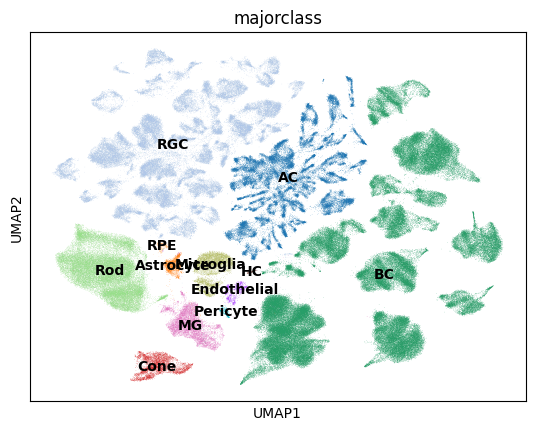

In [57]:
sc.pl.umap(
    filtered_adata,
    color=["majorclass"],
    wspace=.2,
    legend_loc="on data",
)

In [58]:
adata = filtered_adata

### Normalization

In [59]:
# Saving count data
adata.layers["raw"] = adata.X.copy()

/tmp/ipykernel_296565/1507674632.py:2: ImplicitModificationWarning: Setting element `.layers['raw']` of view, initializing view as actual.
  adata.layers["raw"] = adata.X.copy()


In [60]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

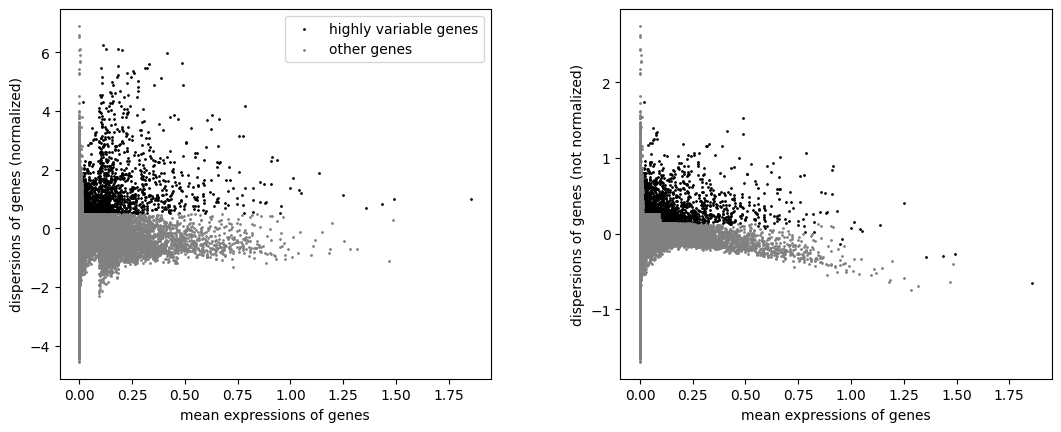

In [61]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

How is dispersion measured when there's no section sample?

### PCA

In [62]:
sc.tl.pca(adata)

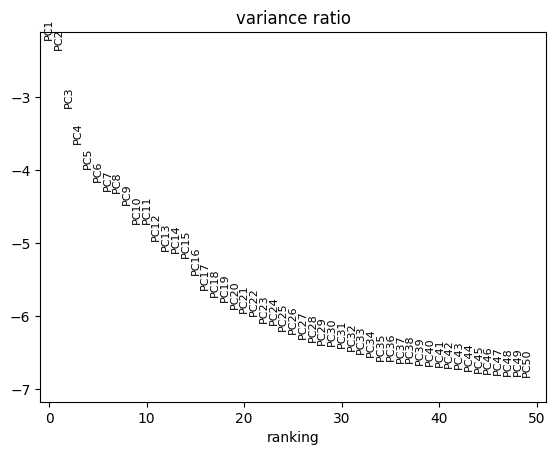

In [63]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

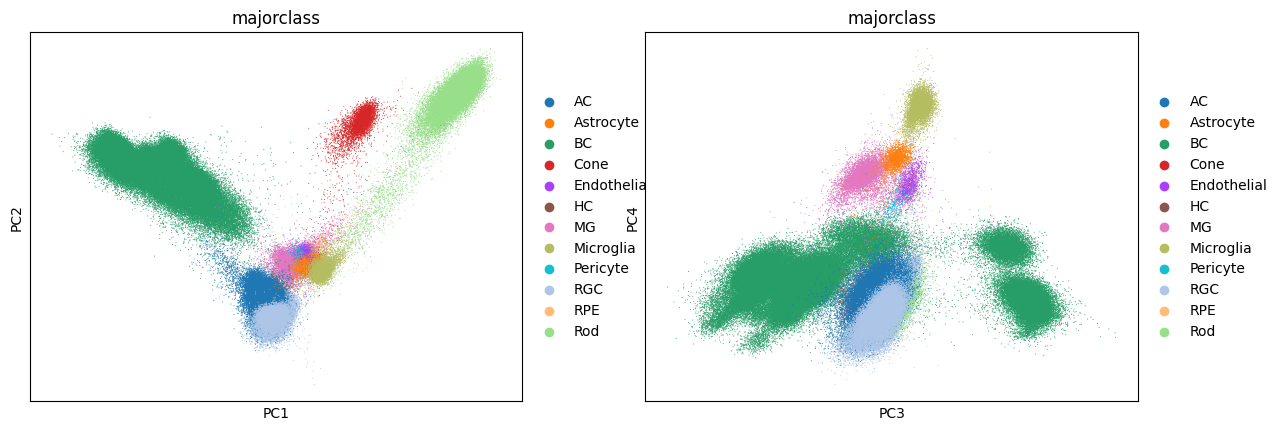

In [64]:
sc.pl.pca(
    adata,
    color=["majorclass"],
    dimensions=[(0, 1), (2, 3)],
    ncols=2,
    size=2,
)

## Clustering

In [65]:
sc.pp.neighbors(adata)

In [66]:
for res in [0.02, 0.5, 2.0]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph"
    )

In [67]:
print(adata)

AnnData object with n_obs × n_vars = 312186 × 32034
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'pANN', 'sampleid', 'subclass_label', 'majorclass', 'author_cell_type', 'age', 'gender', 'reference', 'accession', 'sample_note', 'development_stage_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'donor_id', 'organism_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'tissue_type', 'library_platform', 'cell_type_ontology_term_id', 'is_primary_data', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden_res_0.02', 'leiden_res_0

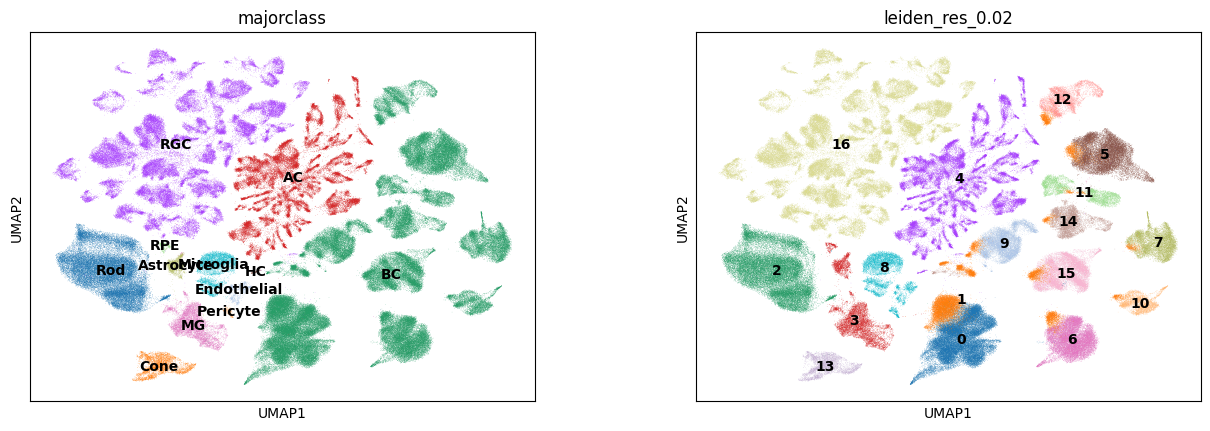

In [77]:
sc.pl.umap(
    adata,
    color=["majorclass", "leiden_res_0.02"],
    wspace=.2,
    legend_loc="on data",
)

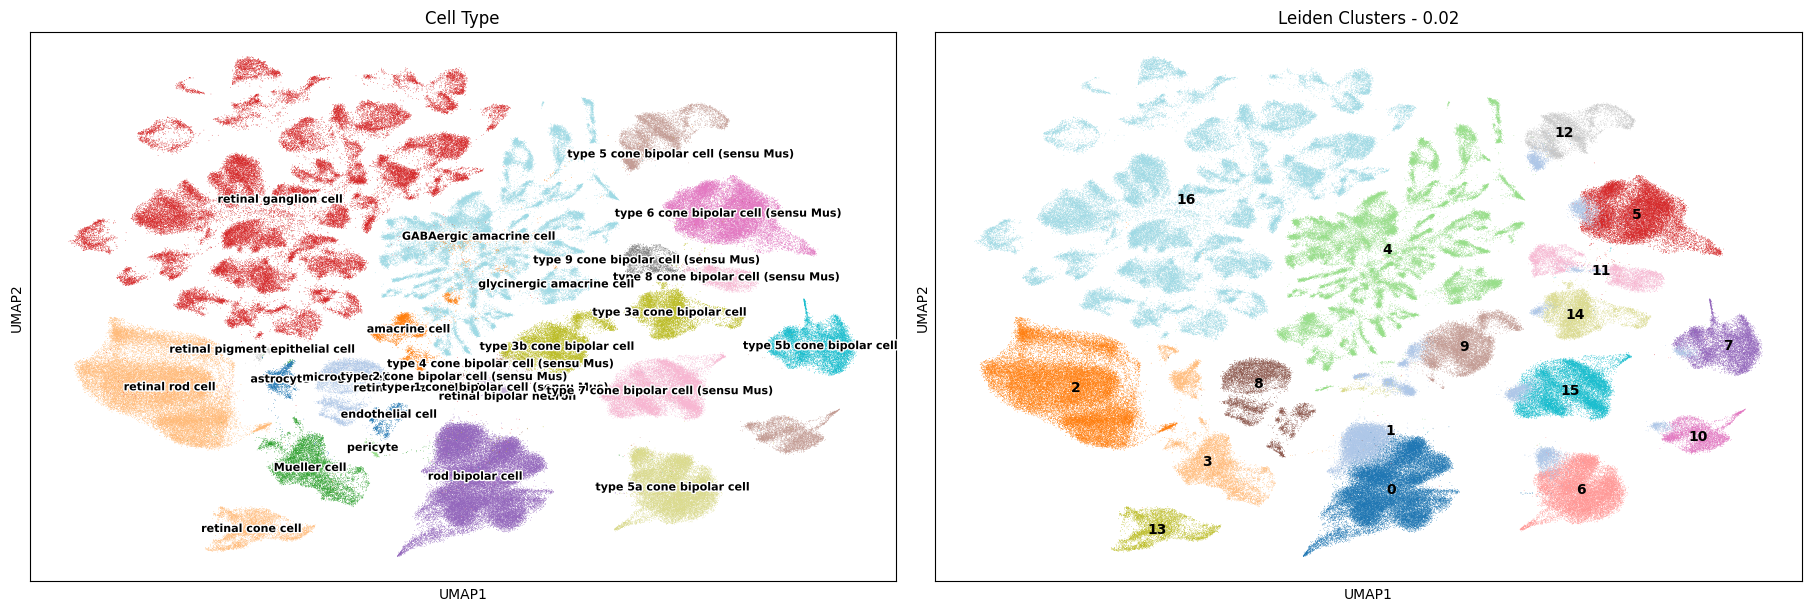

In [97]:
# Create UMAP plots horizontally with adjusted legends
fig, axs = plt.subplots(1, 2, figsize=(18, 6), constrained_layout=True)

# Plot the first UMAP
sc.pl.umap(adata, color="cell_type", ax=axs[0], palette='tab20', legend_loc='on data', size=1, legend_fontsize=8, legend_fontoutline=2, title='Cell Type', show=False, wspace=.5)

# Plot the second UMAP
sc.pl.umap(adata, color="leiden_res_0.02", ax=axs[1], palette='tab20', legend_loc='on data', size=1, title='Leiden Clusters - 0.02', show=False, wspace=.5)

plt.show()

Based on gene expression data, bipolar cells exhibit greater heterogeneity within themselves compared to other major cell types. This is shown by the clustering, which separates bipolar cells into distinct subgroups while not segregating other major cell types as distinctly.

## Gene Expression Analysis

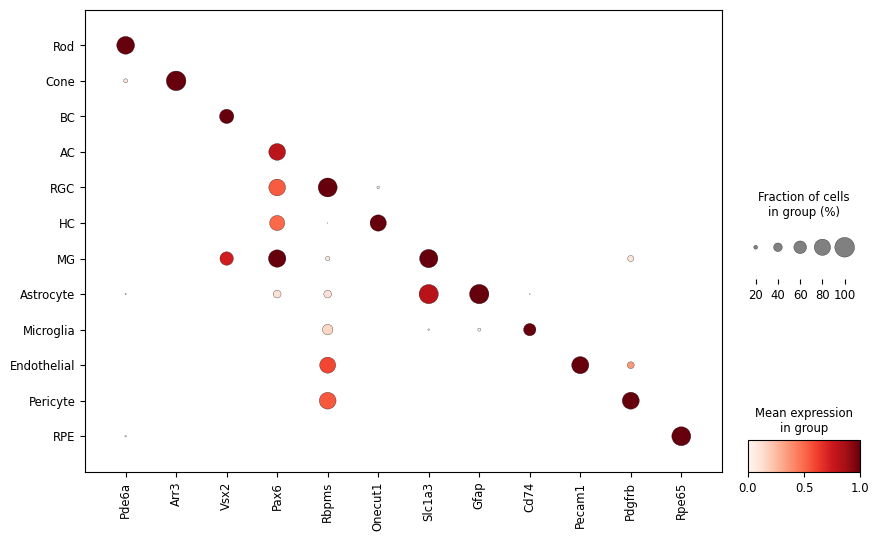

In [86]:
# List of gene symbols in the desired order
gene_symbols = ['Pde6a', 'Arr3', 'Vsx2', 'Pax6', 'Rbpms', 'Onecut1', 'Slc1a3', 'Gfap', 'Cd74', 'Pecam1', 'Pdgfrb', 'Rpe65']

# Ensure that 'majorclass' in adata.obs is a categorical variable
# and order the categories as desired
cell_type_order = ['Rod', 'Cone', 'BC', 'AC', 'RGC', 'HC', 'MG', 'Astrocyte', 'Microglia', 'Endothelial', 'Pericyte', 'RPE']
adata.obs['majorclass'] = pd.Categorical(adata.obs['majorclass'], categories=cell_type_order, ordered=True)

# Create a dictionary mapping gene symbols to var_names
gene_symbol_to_var_name = {gene_symbol: var_name for gene_symbol, var_name in zip(adata.var['gene_symbols'], adata.var.index) if gene_symbol in gene_symbols}

# Ensure the gene symbols are in the desired order and map them to var_names
ordered_var_names = [gene_symbol_to_var_name[gene] for gene in gene_symbols]

# Plot the dot plot
dotplot = sc.pl.dotplot(
    adata,
    var_names=ordered_var_names,  # List of var_names corresponding to the gene symbols in the desired order
    groupby='majorclass',  # Column in adata.obs to group by (e.g., cell types)
    var_group_labels=gene_symbols,  # Use gene symbols as labels
    standard_scale='var',  # Scale expression per gene (var) or cell type (obs)
    dot_min=0.1,  # Minimum dot size
    dot_max=1,  # Maximum dot size
    color_map='Reds',  # Color map for expression
    figsize=(10, 6),  # Size of the figure
    show=False  # Do not show plot immediately
)

# Customize the x-axis tick labels
ax = dotplot['mainplot_ax']
ax.set_xticks([x + 0.5 for x in range(len(gene_symbols))])  # Shift ticks to the right
ax.set_xticklabels(gene_symbols, rotation=90)

# Show the plot
plt.show()

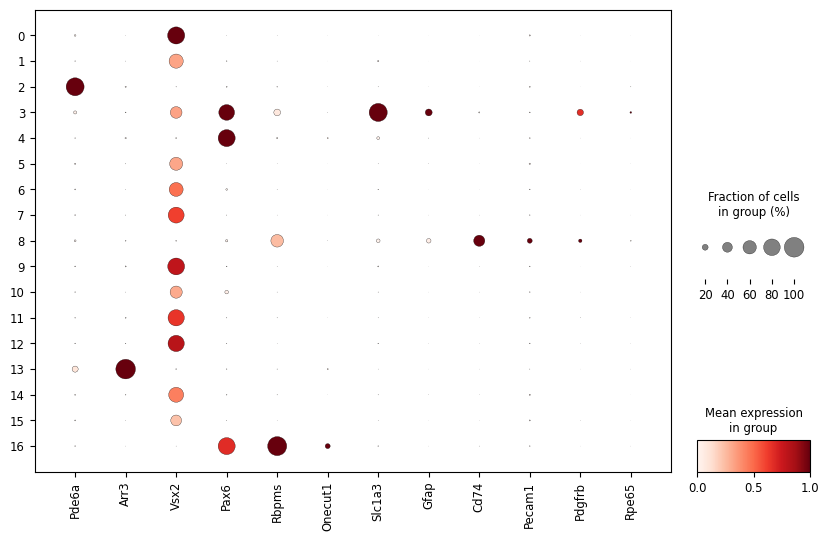

In [87]:
dotplot = sc.pl.dotplot(
    adata, 
    var_names=ordered_var_names, 
    groupby="leiden_res_0.02", 
    standard_scale="var", 
    figsize=(10, 6),  # Size of the figure
    show=False)

# Customize the x-axis tick labels
ax = dotplot['mainplot_ax']
ax.set_xticks([x + 0.5 for x in range(len(gene_symbols))])  # Shift ticks to the right
ax.set_xticklabels(gene_symbols, rotation=90)

# Show the plot
plt.show()

In [90]:
speak("notebook has finished running")

## Quality of Life Stuff

In [73]:
# # Save the entire session
# filename = 'notebook_state.pkl'
# with open(filename, 'wb') as f:
#     dill.dump_session(f)

In [74]:
# import dill

# # Load the saved session
# filename = 'notebook_state.pkl'
# with open(filename, 'rb') as f:
#     dill.load_session(f)

<!-- import dill

# Load the entire session
filename = 'notebook_state.pkl'
with open(filename, 'rb') as f:
    dill.load_session(f) -->